# 4 Joint analysis
## 4.2 Joint analysis of the MuSCAT2 and LCO light curves

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as pf
import pandas as pd

from pathlib import Path
from corner import corner
from astropy.stats import sigma_clip

from pytransit import PhysContLPF, LegendreBaseline, NormalPrior as NP, UniformPrior as UP, LinearModelBaseline
from pytransit.contamination import SMContamination, Instrument, sdss_g, sdss_r, sdss_i, sdss_z
from pytransit.orbits import epoch

In [6]:
%run src/core.py

In [9]:
class LPF(LegendreBaseline, PhysContLPF):
    def __init__(self, name: str, datadir: Path, pattern='*.fits', nlegendre: int = 2):
        pbnames = 'g r i z_s'.split()
    
        times_m, fluxes_m, pbs_m, wns_m = read_m2(reduced_m2_files)
        times_l, fluxes_l, pbs_l, wns_l = read_lco_data()

        times, fluxes, pbs, wns = times_m + times_l, fluxes_m + fluxes_l, pbs_m + pbs_l, wns_m + wns_l
        pbids = pd.Categorical(pbs, categories=pbnames).codes
        
        LegendreBaseline.__init__(self, nlegendre)        
        PhysContLPF.__init__(self, name, pbnames, times, fluxes, pbids=pbids, wnids=arange(len(pbs)))

    def _init_instrument(self):
        """Set up the instrument and contamination model."""
        self.instrument = Instrument('example', [sdss_g, sdss_r, sdss_i, sdss_z])
        self.cm = SMContamination(self.instrument, "i'")
        self.lnpriors.append(lambda pv: where(pv[:, 4] < pv[:, 5], 0, -inf))

In [10]:
lpf = LPF('toi_263_m2_lco_joint', 'results', nlegendre=3)

In [11]:
lpf.set_prior('zero_epoch', NP(zero_epoch.n, zero_epoch.s))
lpf.set_prior('period',     NP(period.n , period.s))
lpf.set_prior('k2_app',     UP(0.12**2, 0.30**2))
lpf.set_prior('teff_h',     NP(3250, 140))

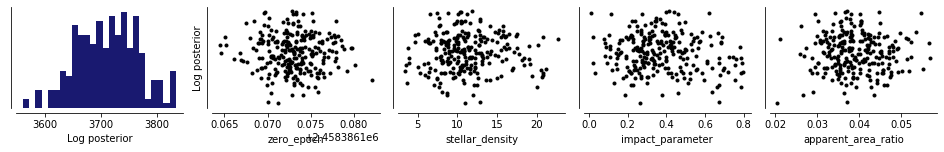

In [12]:
lpf.optimize_global(niter=750, npop=250)

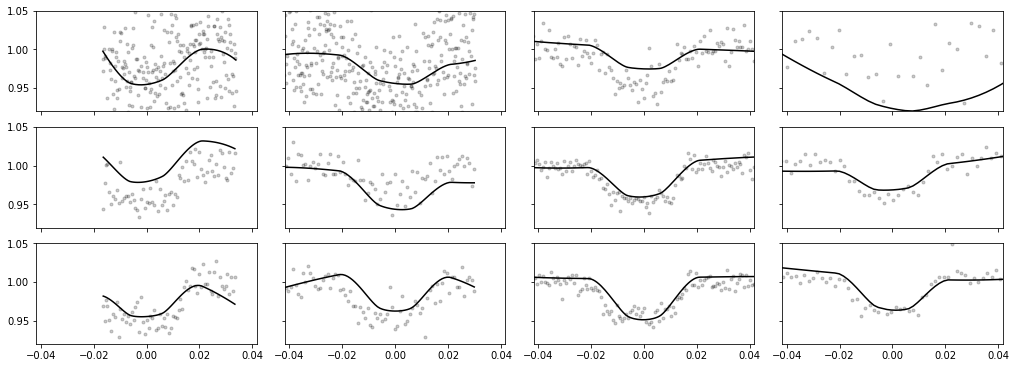

In [13]:
fig, axs = subplots(3, 4, figsize=(14,5), constrained_layout=True, sharex='all', sharey='all')
fmodel = squeeze(lpf.flux_model(lpf.de.minimum_location))
t0, p = lpf.de.minimum_location[0], lpf.de.minimum_location[1]
for i,ax in enumerate(axs.T.flat):
    t = lpf.times[i]
    e = epoch(t.mean(), t0, p)
    tc = t0 + e*p
    ax.plot(t-tc, lpf.fluxes[i], 'k.', alpha=0.2)
    ax.plot(t-tc, fmodel[lpf.lcslices[i]], 'k');
    setp(ax, xlim=(-1/24, 1/24))
setp(axs, ylim=(0.92, 1.05));

In [12]:
lpf._local_minimization = None
lpf.sample_mcmc(10000, thin=50, repeats=5)
lpf.save("results")

In [13]:
df = lpf.posterior_samples(derived_parameters=False)

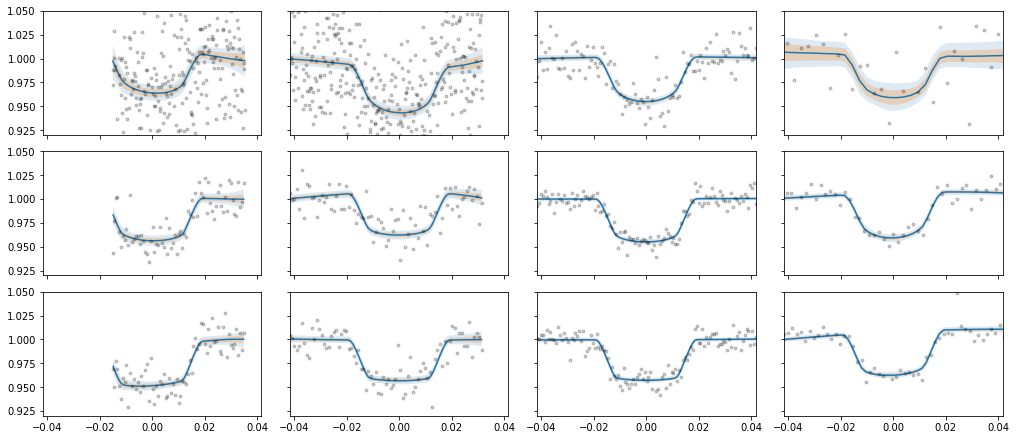

In [14]:
fig, axs = subplots(3, 4, figsize=(14,6), constrained_layout=True, sharex='all', sharey='all')
fmodel = lpf.flux_model(permutation(df.values)[:1000])
fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)

t0, p = lpf.de.minimum_location[0], lpf.de.minimum_location[1]
for i,ax in enumerate(axs.T.flat):
    t = lpf.times[i]
    e = epoch(t.mean(), t0, p)
    tc = t0 + e*p
    ax.fill_between(t-tc, *fmperc[3:5, lpf.lcslices[i]], alpha=0.15)
    ax.fill_between(t-tc, *fmperc[1:3, lpf.lcslices[i]], alpha=0.25)
    ax.plot(t-tc, fmperc[0, lpf.lcslices[i]])
    ax.plot(t-tc, lpf.fluxes[i], 'k.', alpha=0.2)
    setp(ax, xlim=(-1/24, 1/24))
setp(axs, ylim=(0.92, 1.05));

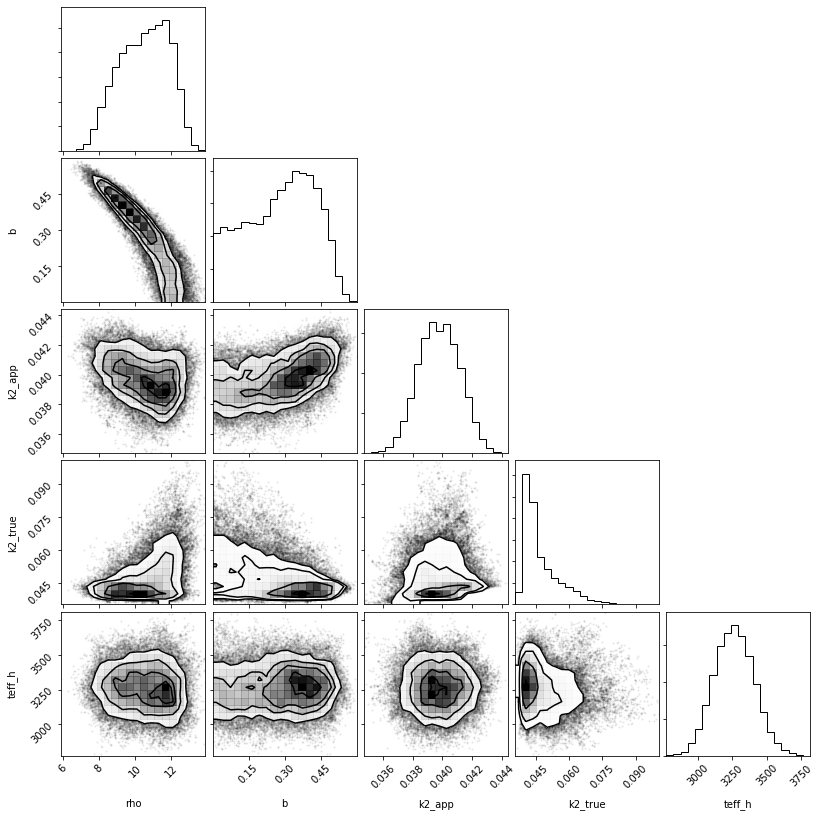

In [15]:
corner(df.iloc[:,2:7]);

---


<center> © 2019 Hannu Parviainen </center>